# Machine Learning Project

## Introduction

The aim of this project is to predict the presence of heart disease using a dataset obtained from the UCL Machine Learning repository. The dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/statlog+%28heart%29). 

*INSERT OUTLINE OF METHODOLOGY AFTER PROJECT* classifiers are KNN, DT, NB, RF

## Data Description

Our data consists of 270 instances with 13 descriptive features, and a target feature having two classes which indicate the presence or absence of heart disease. Hence, this is a binary classification problem. As is, our dataset contains no missing values.

The following explanation of the descriptive features is extracted from the dataset description on the [UCL website](https://archive.ics.uci.edu/ml/datasets/statlog+%28heart%29):
* age - **numerical**
* sex - **binary**
* chest pain type - **nominal**
* resting blood pressure - **numerical**
* serum cholestoral in mg/dl - **numerical**      
* fasting blood sugar > 120 mg/dl - **binary**
* resting electrocardiographic results - **nominal**
* maximum heart rate achieved - **numerical**
* exercise induced angina - **binary**
* oldpeak = ST depression induced by exercise relative to rest - **numerical**
* the slope of the peak exercise ST segment - **ordinal**
* number of major vessels (0-3) colored by flourosopy - **numerical**    
* thal (3 = normal; 6 = fixed defect; 7 = reversible defect) - **nominal**

Each of the nominal features has been integer encoded, which is a miselading representation of the data and will be addressed in the processing stage. 

Time to import our dataset as well as any modules we will be using, and do some preliminary configuration.

In [1]:
# for plotting
# !pip install --upgrade pip
# !pip install --upgrade altair
# !pip install vega vega_datasets

In [2]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
import pandas as pd
import numpy as np

# Ignore python warnings
import warnings
warnings.filterwarnings('ignore')

# set random state for reproducibility
random_seed = 999

# display all columns
pd.set_option('display.max_columns', None) 

# handle figure numbers
fignr = list(range(1,100))

# read in and configure data with column names
# col_names = ['age', 'sex', 'chest_pain_type', 'resting_bp', 'serum_cholestoral', 'fasting_blood_sugar', 'resting_ecg_results', 'max_hr_achieved', 'exercise_induced_angina', 'oldpeak', 'slope_of_peak_exercise', 'no_of_major_vessels', 'thal', 'target']
# these names are abbreviated below for space
col_names = ['age', 'sex', 'cpt', 'rb', 'sc', 'fbs', 'rer', 'mha', 'eia', 'old', 'sope', 'nomv', 'thal', 'target'] 
full_data = pd.read_csv('heart.csv',names=col_names,header=None)

# separate target feature
target = full_data['target']
data = full_data.copy()
data.drop(columns=['target'],inplace=True)

In [4]:
full_data.head()

,age,sex,cpt,rb,sc,fbs,rer,mha,eia,old,sope,nomv,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


Now that we have our dataset imported and our target feature separated we can have a brief look at our dataset using python.

In [5]:
print("----------")
print(f"Shape of the dataset is {data.shape} \n")
print("----------")
print(f"Each of the descriptive features have the following types:\n{data.dtypes}\n")
print("----------")
print(f"Each of the descriptive features have the following number of unique values:\n{data.nunique()}\n")
print("----------")
print(f"The dataset contains no missing values:\n{data.isna().sum()}\n")

----------
Shape of the dataset is (270, 13) 

----------
Each of the descriptive features have the following types:
age     float64
sex     float64
cpt     float64
rb      float64
sc      float64
fbs     float64
rer     float64
mha     float64
eia     float64
old     float64
sope    float64
nomv    float64
thal    float64
dtype: object

----------
Each of the descriptive features have the following number of unique values:
age      41
sex       2
cpt       4
rb       47
sc      144
fbs       2
rer       3
mha      90
eia       2
old      39
sope      3
nomv      4
thal      3
dtype: int64

----------
The dataset contains no missing values:
age     0
sex     0
cpt     0
rb      0
sc      0
fbs     0
rer     0
mha     0
eia     0
old     0
sope    0
nomv    0
thal    0
dtype: int64



## Data Preparation
<a id='dataprep'></a>
While our dataset comes to us fairly clean, there is still much data preparation to do before we can get to the business of predictive modelling.

First of all, we must integer encode the target feature. It currently holds the values (1) for the absence of heart disease, and (2) for the presence of heart disease. Since the presence is our postive feature, we wish to map this to (1) and the absence to (0).

In [6]:
# firstly we integer encode target feature 
print("Target before encoding: ",np.unique(target,return_counts=True))
encoded_target = np.where(target==1,0,1)
print("Target after encoding: ",np.unique(encoded_target,return_counts=True))

Target before encoding:  (array([1, 2]), array([150, 120]))
Target after encoding:  (array([0, 1]), array([150, 120]))


We now turn to our nominal features (chest pain type, resting electrocardiographic results, and thal) which have been integer encoded. As integer encoding assumes an ordering, we consider it bad practice to integer encode nominal features, so we will undo this encoding to repace it with a one-hot encoding scheme.

In [7]:
# output the value counts for variable 'cpt'
print(f"Before processing the variable \"cpt\" has the following value counts:\n{data['cpt'].value_counts()}\n")

# we then map each of them to the following categorical levels
cpt_mappings = {1.0 : 'cpt1', 2.0 : 'cpt2', 3.0 : 'cpt3', 4.0 : 'cpt4'}
data['cpt'].replace(cpt_mappings,inplace=True)

# output the result
print(f"After processing the variable \"cpt\" has the following value counts:\n{data['cpt'].value_counts()}\n")

# output the value counts for variable 'rer'
print(f"Before processing the variable \"rer\" has the following value counts:\n{data['rer'].value_counts()}\n")

# we then map each of them to the following categorical levels
rer_mappings = {0.0 : 'rer0', 1.0 : 'rer1', 2.0 : 'rer2'}
data['rer'].replace(rer_mappings,inplace=True)

# output the result
print(f"After processing the variable \"rer\" has the following value counts:\n{data['rer'].value_counts()}\n")

# output the value counts for variable 'thal'
print(f"Before processing the variable \"thal\" has the following value counts:\n{data['thal'].value_counts()}\n")

# we then map each of them to the following categorical levels
thal_mappings = {3.0 : 'thal3', 6.0 : 'thal6', 7.0 : 'thal7'}
data['thal'].replace(thal_mappings,inplace=True)

# output the result
print(f"After processing the variable \"thal\" has the following value counts:\n{data['thal'].value_counts()}\n")

Before processing the variable "cpt" has the following value counts:
4.0    129
3.0     79
2.0     42
1.0     20
Name: cpt, dtype: int64

After processing the variable "cpt" has the following value counts:
cpt4    129
cpt3     79
cpt2     42
cpt1     20
Name: cpt, dtype: int64

Before processing the variable "rer" has the following value counts:
2.0    137
0.0    131
1.0      2
Name: rer, dtype: int64

After processing the variable "rer" has the following value counts:
rer2    137
rer0    131
rer1      2
Name: rer, dtype: int64

Before processing the variable "thal" has the following value counts:
3.0    152
7.0    104
6.0     14
Name: thal, dtype: int64

After processing the variable "thal" has the following value counts:
thal3    152
thal7    104
thal6     14
Name: thal, dtype: int64



Now that we've undone the integer encoding, we're ready to apply one-hot encoding to these nominal variables.

In [8]:
# one-hot encode
data = pd.get_dummies(data)
# display transformed data
data.head()

,age,sex,rb,sc,fbs,mha,eia,old,sope,nomv,cpt_cpt1,cpt_cpt2,cpt_cpt3,cpt_cpt4,rer_rer0,rer_rer1,rer_rer2,thal_thal3,thal_thal6,thal_thal7
0,70.0,1.0,130.0,322.0,0.0,109.0,0.0,2.4,2.0,3.0,0,0,0,1,0,0,1,1,0,0
1,67.0,0.0,115.0,564.0,0.0,160.0,0.0,1.6,2.0,0.0,0,0,1,0,0,0,1,0,0,1
2,57.0,1.0,124.0,261.0,0.0,141.0,0.0,0.3,1.0,0.0,0,1,0,0,1,0,0,0,0,1
3,64.0,1.0,128.0,263.0,0.0,105.0,1.0,0.2,2.0,1.0,0,0,0,1,1,0,0,0,0,1
4,74.0,0.0,120.0,269.0,0.0,121.0,1.0,0.2,1.0,1.0,0,1,0,0,0,0,1,1,0,0


Now that our descriptive features are encoded correctly we can scale our data.

In [9]:
from sklearn import preprocessing

# save a copy of the original data
data_copy = data.copy()
# perform scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(data)
data = scaler.fit_transform(data)

Our data has now been processed and scaled and we're ready to move to the next section.

## Data Exploration & Visualisation

\# TODO: REMOVE THIS CELL
- A group of 2 members: at least 3 plots of each one of the following: one-variable plots, two-variable plots, and three-variable plots (minimum 9 plots).
- These plots must be meaningful and they need to make sense with respect to the goals and objectives of your project.

Using the original data with full naming of the columns to better analyze the plots from different combinations of the data features. Also encoding the original data to not interfere with the data preparation completed for further analysis in next section of Feature Ranking and so on.

In [22]:
col_names = ['age', 'sex', 'chest pain type', 'resting bp', 'serum cholestoral', 
'fasting blood sugar', 'resting ecg results', 'max hr achieved', 'exercise induced angina', 
'oldpeak', 'slope of peak exercise', 'no of major vessels', 'thal', 'target']
data2 = full_data.copy()
data2.columns = col_names

# Encoding target (1,2) which means absence/presence of heart disease to (0,1) according to discussion above
df_temp = data2.assign(encoded_target=(data2['target'] + 1) % 2)
data2['target'] = df_temp['encoded_target']
data2.head()

,age,sex,chest pain type,resting bp,serum cholestoral,fasting blood sugar,resting ecg results,max hr achieved,exercise induced angina,oldpeak,slope of peak exercise,no of major vessels,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


The plot below show the amount of each levels partition. These are numbers to take into account when making plots further and analysing the result. 

Analysing the plots below shows that:

- There is a double amount of gender 1.0 than 0.0 
- The chest pain type 1.0 has about 20 patients which is a very low number of data to draw conclusion on

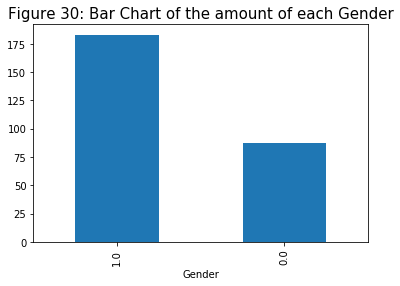

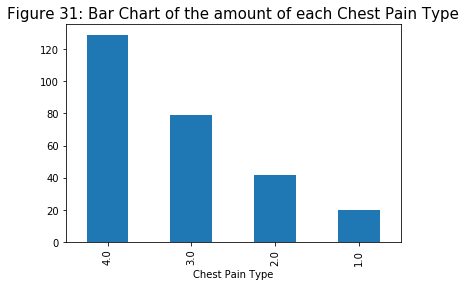

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = data2['sex'].value_counts().plot(kind = 'bar')
plt.title('Figure {}: Bar Chart of the amount of each Gender'.format(fignr.pop(0)), fontsize = 15)
plt.xlabel('Gender')
plt.show();

# Controlling the distribution and amount of each of the chest pain types
ax = data2['chest pain type'].value_counts().plot(kind = 'bar')
plt.title('Figure {}: Bar Chart of the amount of each Chest Pain Type'.format(fignr.pop(0)), fontsize = 15)
plt.xlabel('Chest Pain Type')
plt.show();

The boxplot in below shows that the median of age for the disease is around 55 years and the interquartile between the ages of around 48 to 62 years. It is not skewed in any directions which shows that the data is normal distribution. #TODO: Change descprition depending...

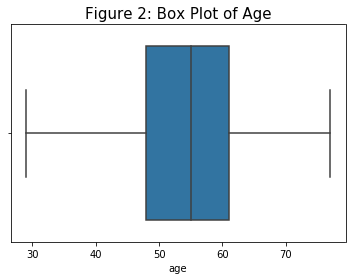

In [12]:
sns.boxplot(data2['age']).set_title('Figure {}: Box Plot of Age'.format(fignr.pop(0)), fontsize = 15)
plt.show();

The distribution can be shown in a histogram in figure 3.

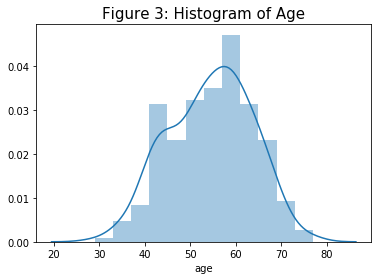

In [13]:
# TODO: REMOVE because boxplot visualisation is easier to analyse
# # get a histogram of age with kernel density estimate
# sns.distplot(data2['age'], kde = True).set_title('Figure {}: Histogram of Age'.format(fignr.pop(0)), fontsize = 15)
# plt.show();

The histogram shows the probability (y-axis) of each resting blood pressure (x-axis) and showing the kernel density as the line. The histogram and boxplot below shows that the median of the resting bloodpressure is around 130 which is a little bit above the desired blodpressure of 120. #TODO: backup this up

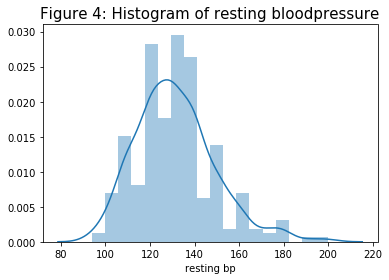

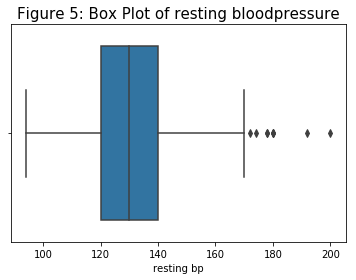

In [14]:
feature = 'resting bp'
sns.distplot(data2[feature], kde = True).set_title('Figure {}: Histogram of resting bloodpressure'.format(fignr.pop(0)), fontsize = 15)
plt.show();
sns.boxplot(data2[feature]).set_title('Figure {}: Box Plot of resting bloodpressure'.format(fignr.pop(0)), fontsize = 15)
plt.show();

The figure below show that the age of each gender is very similar, but with a slight difference where gender '1.0' is on average younger than gender '0.0'. The minimum age is about 5 years younger. #TODO:

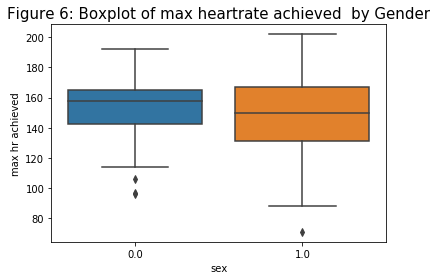

In [15]:
# Creating a boxplot
sns.boxplot(data2['sex'], data2['max hr achieved']);
plt.title('Figure {}: Boxplot of max heartrate achieved  by Gender'.format(fignr.pop(0)), fontsize = 15)
plt.show();

The numerical features are: age, resting bp, serum cholestoral number, max heart rate achieved and old peak which can be used to show different combinations of data. The five plots below shows the correlation between the diagnosed heart disease and the numerical factors. Some conclusion can be drawn from these, which is that the patients diagnosed with heart disease compared to the healthy patients have in general:

- A higher age
- A higher resting blood pessure
- Approximately the same serum cholestoral but with a small higher difference
- A significantly lower achieved maximum heart rate
- A significantly higher oldpeak value (ST depression induced by exercise relative to rest)


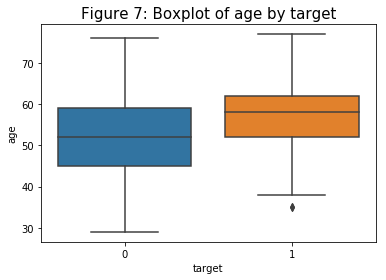

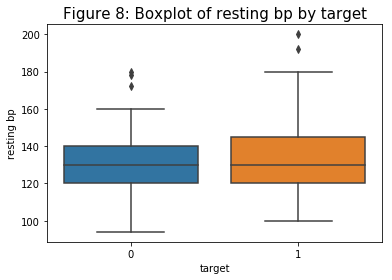

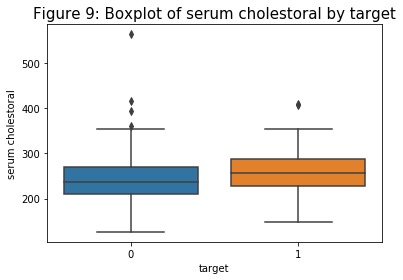

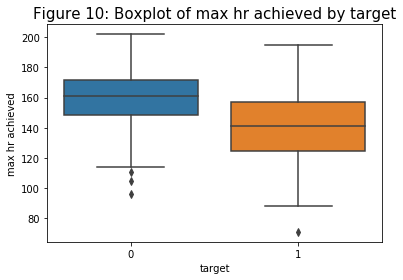

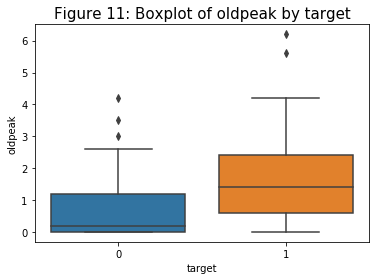

In [16]:
def show_2feature_boxplot(data, f1_nom=None, f2_num=None):
    sns.boxplot(data[f1_nom], data2[f2_num]);
    plt.title('Figure {}: Boxplot of {} by {}'.format(fignr.pop(0), f2_num, f1_nom), fontsize = 15)
    plt.show();

# show_2feature_boxplot(data2, f1_nom='sex', f2_num='resting bp')
show_2feature_boxplot(data2, f1_nom='target', f2_num='age')
show_2feature_boxplot(data2, f1_nom='target', f2_num='resting bp')
show_2feature_boxplot(data2, f1_nom='target', f2_num='serum cholestoral')
show_2feature_boxplot(data2, f1_nom='target', f2_num='max hr achieved')
show_2feature_boxplot(data2, f1_nom='target', f2_num='oldpeak')

To be able to analyse more of the nominal features combined with a numerical feature and the target, multivariate plots are introduced. The nominal features  include sex/gender, chest pain type, fasting blood sugar, resting ecg results, exercise induced angina, slope of peak exercise, no of major vessels and thal. 

Below is the combination of age (numerical), chest pain type (nominal, 4 levels) and sex (nominal, 2 levels) combined. The result shows that difference of age with the different chest pain types varies a lot more with gender 0.0 than for gender 1.0

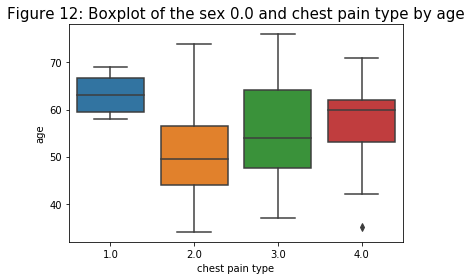

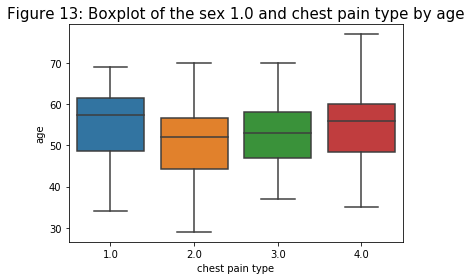

In [17]:
# Show 3 features, where one is numerical (f1) and two is nominal (f2, f3) with only one chosen level on the latter feature (f3)
def show_3feature_boxplot(data, f1, f2, f3, f3_level):
    levels = data[f2].unique().tolist()
    
    # Make a mask of f2 and f3 with f3's chosen level
    mask = (data[f2].isin(levels)) & (data[f3].isin([f3_level]))
    mask_level = data[mask]
    sns.boxplot(mask_level[f2], mask_level[f1]);
    plt.title('Figure {}: Boxplot of the {} {} and {} by {}'.format(fignr.pop(0), f3, f3_level, f2, f1), fontsize = 15)
    plt.show();

# Showing two plots for each gender
show_3feature_boxplot(data2, 'age', 'chest pain type', 'sex', '0.0')
show_3feature_boxplot(data2, 'age', 'chest pain type', 'sex', '1.0')

To get a better view of the features combined a multivariate plot of three features can be shown using the method below. 

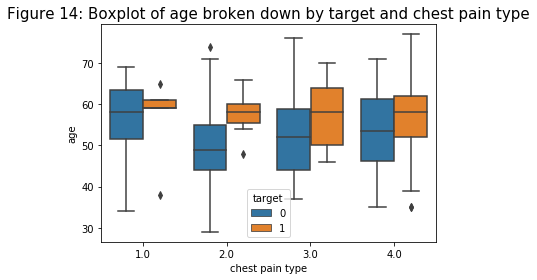

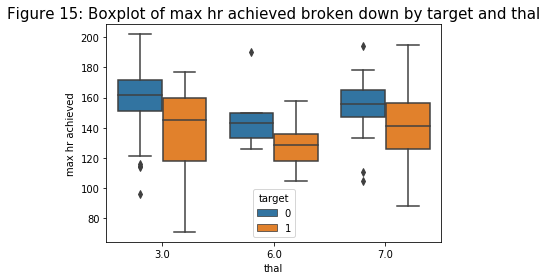

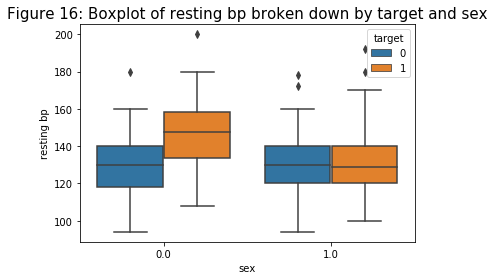

In [19]:
# Show 3 features, where one is numerical (f1) and two is nominal (f2, f3). Notice that f2 levels needs to be max 2 like Gender
def show_4feature_boxplot(data, f1, f2, f3):
    # Getting the index of those who have completed their Bachelors or HS graduate
    levels = data2[f2].unique().tolist()
    f2_mask = data2[f2].isin(levels)

    # Getting the index of those who are male and Not_in_family or a Husband
    levels_f3 = data2[f3].unique().tolist()
    f3_level1_mask = (data2[f3].isin(levels_f3)) & (data2[f2].isin([levels[0]]))
    f3_level2_mask = (data2[f3].isin(levels_f3)) & (data2[f2].isin([levels[1]]))

    # Selecting the rows of those who are Not_in_family, husband or wife and 
    # have completed either a Bachelors or just graduated high school
    f2_f3_mask = data2[(f2_mask & f3_level2_mask) | (f2_mask & f3_level1_mask)]

    # Creating the boxplot
    sns.boxplot(f2_f3_mask[f3], f2_f3_mask[f1], 
                hue = f2_f3_mask[f2])
    plt.title('Figure {}: Boxplot of {} broken down by {} and {}'.format(fignr.pop(0), f1, f2, f3), fontsize = 15)
    plt.show();
    
show_4feature_boxplot(data2, 'age', 'target', 'chest pain type')
show_4feature_boxplot(data2, 'max hr achieved', 'target', 'thal')
show_4feature_boxplot(data2, 'resting bp', 'target', 'sex')

The plots above \# TODO: draw conclusions

To easier display a combination of numerical features a scatter plot has been used. They can present two features that are numerical and one nominal feature, and these are shown below with some different combinations.

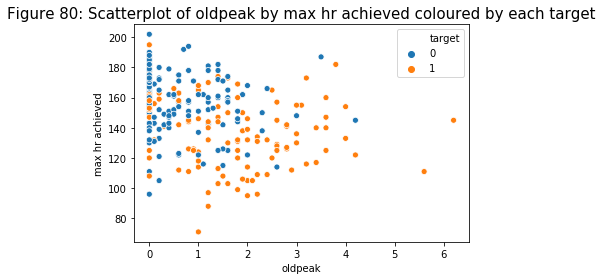

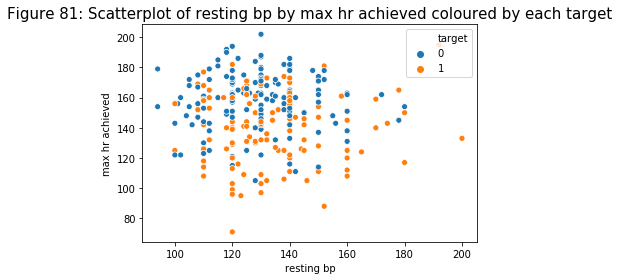

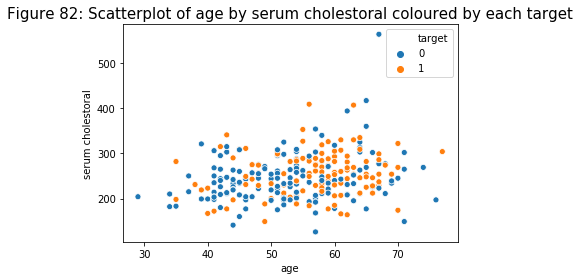

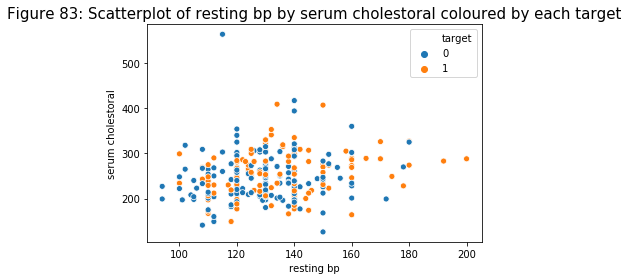

In [50]:
# Show a scatterplot of 3 features where f1 is nominal and f2 and f3 is numerical
def show_scatterplot(data, f1, f2, f3):
    # Getting the index of those in feature 1
    f1_levels = data2[f1].unique().tolist()
    mask = data2[f1].isin(f1_levels)

    # creating a dataframe of those in feature1
    f1_df = data2[mask]

    # creating a scatterplot
    sns.scatterplot(f1_df[f2], f1_df[f3], hue = f1_df[f1])
    plt.title('Figure {}: Scatterplot of {} by {} coloured by each {}'.format(fignr.pop(0), f2, f3, f1), fontsize = 15);
    plt.legend(loc = 'upper right')
    plt.show();

show_scatterplot(data2, 'target', 'oldpeak','max hr achieved')
show_scatterplot(data2, 'target', 'resting bp', 'max hr achieved')
show_scatterplot(data2, 'target', 'age', 'serum cholestoral')
show_scatterplot(data2, 'target', 'resting bp', 'serum cholestoral')

The conclusions from the scatterplots are: \# TODO: CONCLUSION


# Predictive Modelling

\#TODO: REMOVE THIS

(40 points) Predictive Modelling:
- (5 points) A complete overview of your methodology.
- (15 points) Details of feature selection, the algorithms’ fine-tuning process, relevant fine-tuning plots, and detailed performance analysis of each algorithm.
- (10 points) Performance comparison of the algorithms as appropriate (cross-validation, AUC, etc.) using paired t-tests.
- (10 points) A critique of your approach: underlying assumptions, its limitations, its strengths and its weaknesses.
NOTE 2: For this Assessment Criteria #5 (that is worth 40 points), your work will be marked on your methodology, not absolute performance of your algorithms.

## Cross-Validation
To assess the performance of our models we will be using repeated stratified 10-fold cross-validation with 5 repetitions. Stratified cross-validation was selected to ensure the proportion of positive and negatives labels in the target is preserved in each repetition. - CHECK WHETHER THIS IS THE BEST WAY TO DO IT

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=10, 
                                    n_repeats=5, 
                                    random_state=random_seed)

## Feature Selection
We will peform feature selection using random forest importance (RFI) on our dataset to determine whether an optimal subset of our descriptive features might give better performance. 

In [ ]:
'''
CLEAN THIS UP JUST MAKING SURE IT RUNS PROPERLY ETC
'''
# for plotting
import altair as alt
alt.renderers.enable('notebook')

from sklearn import feature_selection as fs
from sklearn.ensemble import RandomForestClassifier

# intially we wish to asses the importance of all of our features

num_features = 20

model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(data, encoded_target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

# get all features in sorted order of importance
best_features_rfi = data_copy.columns[fs_indices_rfi].values

# get their importances
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]

# taken from SK2
def plot_imp(best_features, scores, method_name, x_label, y_label):
    
    df = pd.DataFrame({x_label : best_features, 
                       y_label : scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name,
                     ).mark_bar(opacity=0.75, 
                                color='blue').encode(
        alt.X(x_label, title=x_label, sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y(y_label, title=y_label)
    )
    
    return chart

# plot
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest Feature Importances','features','importances')

In the above graph we can see the importances of all of our descriptive features sorted in descreasing order of importance. Let us now measure the accuracy of a number of feature subsets to determine if one is optimal using a KNN classifier using the eulidean distance metric with n=5 neighbours.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

fs_knn = KNeighborsClassifier(n_neighbors=5)

num_features = [x for x in range(5,21)]

accuracy_scores = list()

for n in num_features:
    
    # subset data into the first n most important features
    subset = data[:, fs_indices_rfi[:n]]
    
    # assess accuracy and record
    cv_results_fs = cross_val_score(estimator=fs_knn,
                             X=subset,
                             y=encoded_target, 
                             cv=cv_method, 
                             scoring='accuracy')

    accuracy_scores.append(cv_results_fs.mean().round(3))
    
# display scores in sorted order
acc_df = pd.DataFrame({'num_features': num_features, 
                       'accuracy': accuracy_scores}).sort_values(by=['accuracy'])
acc_df

Above we see that using only the 6 (THIS VALUE WILL CHANGE) most important features yields us the greatest accuracy. However, due to constraints placed upon our dataset (i.e. a minimum of 7 descriptive features) we will select the first 9, which our tests indicate is practically the same as choosing 6 in terms of accuracy. We therefore subset our data accordingly before proceeding.

In [ ]:
#data = data[:, fs_indices_rfi[:9]] # this value can change! be careful!
data.shape

## Hyperparameter Tuning
In order to ensure that our machine learning models are optimal, it is necessary to perform hyperparameter tuning. The models we will be optimising are: K-nearest neighbours, decision tree, random forest, and naive bayes. Grid search is used to determine optimal parameters.

### Train-test Splitting
To fit and evaluate our models we require that our data be split into training and testing sets. Note that to preserve the proportion of positive and negative instances of our target across the training and test sets we set the stratify option to the target.

In [ ]:
from sklearn.model_selection import train_test_split

d_train, d_test,t_train, t_test = train_test_split(data, encoded_target, 
                                                    test_size = 0.3, 
                                                    stratify = encoded_target,   
                                                    random_state=random_seed)

print(d_train.shape)
print(d_test.shape)

### KNN

### Decision Tree

### Naive Bayes

### Random Forest

## Model Fitting and Performance Evaluation

The predictions of the test data is made using the grid searched K-Nearest Neighbour. Then the Sci-Kit model metrics is used to calculate the accuracy of the predicted test data. This is based on that t_test is the actual values of the target and is then compared to the predicted values of the test data, t_pred.

In [ ]:
# gs_KNN is the grid search on K-Nearest Neighbours done under Hypertuning part
from sklearn import metrics
t_pred = gs_KNN.predict(d_test)
metrics.accuracy_score(t_test, t_pred)
# metrics.recall_score(t_test, t_pred) # TODO: Difference from above?

### Confusion Matrix, precision, recall and F1-score
To analyse the outcome of the predictions further a confusion matrix will be made. Metrics to be used to study the outcome are precision, recall (True Positive Rate) and F1-score. These are displayed from the classification_report below for each target.

\#TODO: Check which target is what, makes a big difference on TPR/recall 

In [ ]:
metrics.confusion_matrix(t_test, t_pred)

In [ ]:
print(metrics.classification_report(t_test, t_pred))

### Profit Matrix
\#TODO: do we need this?

### ROC Curves
The ROC curve is a measurement of different predicitors outcome of the True Positive Rate on the False Positive rate, especially good for analysing Binary Classification problems. The area under the ROC curve (AUC) and the F-score are metrics to show how well the predictor is performing.

In [ ]:
perf_metric = 'roc_auc' # TODO: Add to gs_KNN above?

# gs_KNN = GridSearchCV(estimator=model_KNN, 
#                       param_grid=params_KNN, 
#                       cv=cv_method,
#                       verbose=1, 
#                       scoring=perf_metric,
#                       return_train_score=True)

# gs_KNN.fit(d_train, t_train);

# Calculating AUC
metrics.roc_auc_score(t_test, t_pred)

Preparing the data for the ROC curve.

In [ ]:
t_prob = gs_KNN.predict_proba(d_test)
# t_prob[0:10]
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob[:, 1])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

A dataframe is created for False Positive Rate and True Positive Rate below.

In [ ]:
df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df

Visualizing the ROC curve using Altair.

In [ ]:
base = alt.Chart(df, 
                 title='ROC Curve of KNN'
                ).properties(width=300)

roc_curve = base.mark_line(point=True).encode(
    alt.X('fpr', title='False Positive Rate (FPR)',  sort=None),
    alt.Y('tpr', title='True Positive Rate (TPR) (a.k.a Recall)'),
)

roc_rule = base.mark_line(color='green').encode(
    x='fpr',
    y='fpr',
    size=alt.value(2)
)

(roc_curve + roc_rule).interactive()

\# TODO: Analysing where the "elbow", the curve bends, towards TPR=1.
The model indicates that it has a good///bad performance.